<a href="https://colab.research.google.com/github/R12942159/NTU_DLCV/blob/Hw3/p1_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference from https://github.com/openai/CLIP

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tjzfsm61
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-tjzfsm61
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=acb90e0d1f6359d8ba4e9c0fadf418558aefae49f50f12f16fe2acaf3330c069
  Stored in directory: /tmp/pip-ephem-wheel-cache-b5a84_tj/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import os
import re
import csv
import json
import clip
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from google.colab import drive

#### Get cuda from GPU device.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Connect google drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#### Download dataset and unzip zip file.

In [ ]:
!gdown 11rP6KmR5Qwjhx0rfag0b5TZGBTRuPtQR -O hw3_data.zip
!unzip /content/hw3_data.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: hw3_data/p2_data/images/train/000000226677.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000226677.jpg  
  inflating: hw3_data/p2_data/images/train/2832654970.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._2832654970.jpg  
  inflating: hw3_data/p2_data/images/train/000000343951.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000343951.jpg  
  inflating: hw3_data/p2_data/images/train/000000531622.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000531622.jpg  
  inflating: hw3_data/p2_data/images/train/000000176946.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000176946.jpg  
  inflating: hw3_data/p2_data/images/train/000000147543.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000147543.jpg  
  inflating: hw3_data/p2_data/images/train/000000273138.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000273138.jpg  
  inflating: hw3_data/p2_data/images/t

#### Construct image path

In [ ]:
val_path = '/content/hw3_data/p1_data/val'
id2label_path = '/content/hw3_data/p1_data/id2label.json'

img_paths = [os.path.join(val_path, i) for i in os.listdir(val_path) if i.endswith('.png')]
id2label = json.load(open(id2label_path, 'r'))
labels = [l for _, l in id2label.items()]

#### Understand the image size and specifications

This is the image of 1918th, it is a rose.


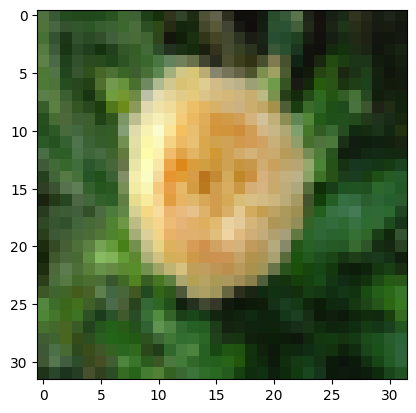

In [ ]:
rd_int = random.randint(0, 2499)
class_num = img_paths[rd_int].split('/')[-1].split('_')[0]
print(f'This is the image of {rd_int}th, it is a {id2label[class_num]}.')

img = Image.open(img_paths[rd_int]).convert('RGB')
img = np.array(img)
img.shape

IMG_SIZE = img.shape[1]

plt.imshow(img)
plt.show()

#### Training with ["RN50"(49.88%), "RN101"(50.92%), "RN50x4"(43.68%), "RN50x16"(58.72%), "RN50x64"(62.05%), "ViT-B/32"(71.16%), "ViT-B/16"(74.6%), "ViT-L/14"(81.44%), "ViT-L/14@336px"(80.68%)]

In [ ]:
_MODEL = ["RN50", "RN101", "RN50x4", "RN50x16", "RN50x64", "ViT-B/32", "ViT-B/16", "ViT-L/14", "ViT-L/14@336px"]

In [ ]:
def train(model_name = "RN50x64"):
    model, transform = clip.load(name=model_name, device=device, jit=False)

    pattern = re.compile(r'[-/@]')
    if pattern.search(model_name):
        model_name = pattern.split(model_name)
        model_name = '_'.join(model_name)

    ID, LABEL= [], []

    for path in tqdm(img_paths):
        img = Image.open(path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device) #  # resize to (1, 3, 448, 448), expected 4D input
        prompt_text = torch.cat(
            [clip.tokenize(f'A photo of a {i}.', context_length=77, truncate=False) for i in labels]
        ).to(device)

        with torch.no_grad():
            img_features = model.encode_image(img) # (1, 1024)
            text_features = model.encode_text(prompt_text) # (50, 1024)

        # Pick the top 1 most similar labels for the image
        img_features /= img_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100. * img_features @ text_features.T).softmax(dim=-1)
        label = similarity[0].argmax()

        ID.append(path.split('/')[-1])
        LABEL.append(label.item()) # torch.Tensor -> int

    # Write output csv file
    with open(f'{model_name}_pred.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(('filename', 'label'))
        for row in zip(ID, LABEL):
            writer.writerow(row)

    return ID, LABEL

In [ ]:
for i in _MODEL:
    ID, LABEL = train(model_name=i)
    GT = [int(i.split('_')[0]) for i in ID]

    correct = []
    for j in range(len(GT)):
        correct.append(LABEL[j] == GT[j])

    print(f'The Model {i} accuracy is: ', np.sum(correct)/len(GT))

100%|██████████| 2500/2500 [02:07<00:00, 19.57it/s]


The Model RN50 accuracy is:  0.4856


100%|████████████████████████████████████████| 278M/278M [00:02<00:00, 102MiB/s]
100%|██████████| 2500/2500 [02:25<00:00, 17.14it/s]


The Model RN101 accuracy is:  0.572


100%|███████████████████████████████████████| 402M/402M [00:08<00:00, 52.6MiB/s]
100%|██████████| 2500/2500 [02:46<00:00, 15.03it/s]


The Model RN50x4 accuracy is:  0.5352


100%|███████████████████████████████████████| 630M/630M [01:23<00:00, 7.90MiB/s]
100%|██████████| 2500/2500 [03:47<00:00, 10.98it/s]


The Model RN50x16 accuracy is:  0.6


100%|█████████████████████████████████████| 1.26G/1.26G [00:27<00:00, 49.4MiB/s]
100%|██████████| 2500/2500 [06:47<00:00,  6.13it/s]


The Model RN50x64 accuracy is:  0.6352


100%|██████████| 2500/2500 [02:12<00:00, 18.84it/s]


The Model ViT-B/32 accuracy is:  0.7004


100%|██████████| 2500/2500 [02:16<00:00, 18.33it/s]


The Model ViT-B/16 accuracy is:  0.7576


100%|██████████| 2500/2500 [03:38<00:00, 11.44it/s]


The Model ViT-L/14 accuracy is:  0.814


100%|██████████| 2500/2500 [04:08<00:00, 10.04it/s]


The Model ViT-L/14@336px accuracy is:  0.808
